# League of Legends Ranked Game 2020 Analysis

In this homework, I am going to analyze the data from the of the most popular PC game: League of Legends. Specifically, I would look in detail what objectives (tower, inhibitor, baron, dragon, etc.) maximize a team's winning chance. The data consists of high ELO ranked matches from the Korean server, which is well known for competitive gaming. The ultimate goal of this analysis is to gain a deep insight into the game and offer strategic suggestions for future gameplays.

Feature explanation:
1. teamId: which side a team takes. 100 for blue side, and 200 for red side.
2. win: whether a team wins or not.
3. firstBlood: whether a team claims first blood.
4. firstTower: whether a team takes down the first tower.
5. firstInhibitor: whether a team takes down the first inhibitor.
6. firstBaron: whether a team slays the first Baron.
7. firstDragon: whether a team slays the first dragon.
8. firstRiftHerald: whether a team slays the first rift herald.
9. towerKills: the total number of towers claimed.
10. inhibitorKills: the total number of inhibitors claimed.
11. baronKills: the total number of Barons slain.
12. dragonKills: the total number of dragons slain.
13. vilemawKills: the total number of Vilemaws slain, not applicable in a 5v5 ranked match.
14. riftHeraldKills: the total number of rift heralds slain.
15. dominionVictoryScore: Score received after a match. not applicable in a 5v5 ranked match.
16. bans: the champion ban/pick status. Not the focus in our study of objectives.
17. gameId: Id of the match.

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import rand_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

Considering the large data size (over 200,000), we train our models using a subset of data. We randomly select 10,000 samples from the winner set and 10,000 samples from the loser set, then merging them together.

In [12]:
winner = pd.read_csv('archive/match_winner_data_version1.csv').dropna().sample(10000)
loser = pd.read_csv('archive/match_loser_data_version1.csv').dropna().sample(10000)

In [13]:
# Merge and shuffle data
data = winner.append(loser)
data = shuffle(data)
data.reset_index(inplace=True, drop=True)

In [14]:
# Drop unnecessary columns
cleaned = data.drop(['teamId', 'Unnamed: 0', 'vilemawKills', 'dominionVictoryScore', 'bans', 'gameId'], axis=1)
y = cleaned['win'].replace('Win', 1).replace('Fail', 0).astype('int64')
X = cleaned.drop('win', axis=1)

# Insight: unsupervised clustering
We first utilize clustering to verify there are indeed noticeable differences between winning and losing team stats. We first perform PCA for the ease of visualization, and then utilize K-means to find the corresponding cluters.

In [195]:
# PCA for visualization

pca = PCA(3)
X_unsupervised = pca.fit_transform(X)
mod_k = KMeans(n_clusters=2)
mod_k.fit(X_unsupervised)

KMeans(n_clusters=2)

In [236]:
rand_score(y, mod_k.labels_)

0.6834204160208011

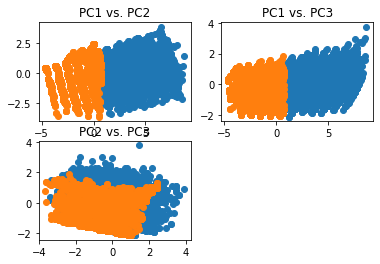

In [232]:
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)

for i in [0,1]:
    ax1.scatter(X_unsupervised[mod_k.labels_==i, 0], X_unsupervised[mod_k.labels_==i, 1], label=i)
    ax2.scatter(X_unsupervised[mod_k.labels_==i, 0], X_unsupervised[mod_k.labels_==i, 2], label=i)
    ax3.scatter(X_unsupervised[mod_k.labels_==i, 1], X_unsupervised[mod_k.labels_==i, 2], label=i)
    
ax1.set_title('PC1 vs. PC2')
ax2.set_title('PC1 vs. PC3')
ax3.set_title('PC2 vs. PC3')
plt.show()

The K means model achieves a satisfying rand score of almost 0.70. In addition, the scatter plot of PCA also reveals a linear separate plane between variables. Only the Principle Compoent 2 and 3 overlap, but it is expected for the matches where neither team gains an advantage until the end during a match.

# Model Comparison
Next, we employ several classification models, train them separately, and compare their performances. Specifically, we make use of Random Forest and Gradient Boosting from the ensemble family, regularized logistic regression, and SVM. All of them have proven to be useful in classification problems. We choose not to perform PCA in order for interpretation. During the training process, we utilize several best practices, including K-fold classification and hyperparamtertuning, to ensure maximum performance of our models.

### Preprocessing

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

scaler = StandardScaler()
# Scale only continuous features
X_train[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'riftHeraldKills']] = scaler.fit_transform(X_train[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'riftHeraldKills']])
X_test[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'riftHeraldKills']] = scaler.transform(X_test[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'riftHeraldKills']])

In [240]:
accs = []

### Ensemble Structures

In [238]:
# Random Forest

rf = GridSearchCV(estimator=RandomForestClassifier(max_features="sqrt"),
                 param_grid={'max_depth': range(1,21,2), 'max_features': range(1, 7)}, cv=3, verbose=1)
rf.fit(X_train, y_train)
rf.best_params_

Fitting 3 folds for each of 60 candidates, totalling 180 fits


{'max_depth': 9, 'max_features': 4}

In [241]:
rf_acc = accuracy_score(y_test, rf.predict(X_test))
accs.append(rf_acc)

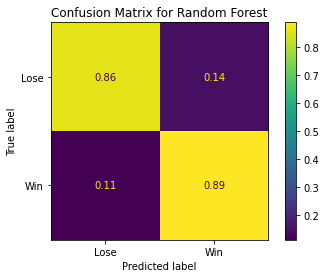

In [281]:
ax = ConfusionMatrixDisplay(confusion_matrix(y_test, rf.predict(X_test), normalize='true'), display_labels=['Lose','Win'])
ax.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [269]:
impts_rf = rf.best_estimator_.feature_importances_
print("Important features identified by Random Forest:")
X_train.columns[np.argsort(-1*impts_rf)[:5]]

Important features identified by Random Forest:


Index(['towerKills', 'inhibitorKills', 'firstInhibitor', 'firstTower',
       'dragonKills'],
      dtype='object')

In [142]:
# Gradient Boosting

gb = GridSearchCV(estimator=GradientBoostingClassifier(),
                 param_grid={'learning_rate': np.linspace(0.1,2.0,10), 'max_depth': range(3,11,2)}, cv=3, verbose=1)
gb.fit(X_train, y_train)
gb.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


{'learning_rate': 0.1, 'max_depth': 5}

In [242]:
gb_acc = accuracy_score(y_test, gb.predict(X_test))
accs.append(gb_acc)

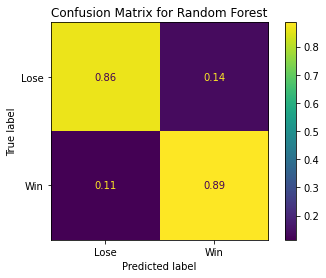

In [282]:
ax = ConfusionMatrixDisplay(confusion_matrix(y_test, gb.predict(X_test), normalize='true'), display_labels=['Lose','Win'])
ax.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [268]:
impts_gb = gb.best_estimator_.feature_importances_
print("Important features identified by Gradient Boosting:")
X_train.columns[np.argsort(-1*impts_gb)[:5]]

Important features identified by Gradient Boosting:


Index(['towerKills', 'inhibitorKills', 'firstTower', 'dragonKills',
       'firstDragon'],
      dtype='object')

### Logistic Regression

In [149]:
log_r = GridSearchCV(estimator=LogisticRegression(penalty='l2', random_state=100),
                    param_grid={'C': [0.0001,0.001,0.01,0.1,1]}, cv=3, verbose=1)
log_r.fit(X_train, y_train)
log_r.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'C': 0.1}

In [243]:
log_r_acc = accuracy_score(y_test, log_r.predict(X_test))
accs.append(log_r_acc)

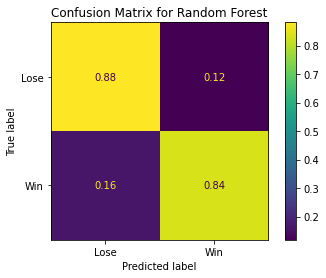

In [283]:
ax = ConfusionMatrixDisplay(confusion_matrix(y_test, log_r.predict(X_test), normalize='true'), display_labels=['Lose','Win'])
ax.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [266]:
impts_logr = log_r.best_estimator_.coef_[0]
print("Important features identified by Logistic Regression:")
X_train.columns[np.argsort(-1*impts_logr)[:5]]

Important features identified by Logistic Regression:


Index(['towerKills', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon'],
      dtype='object')

### SVM

In [187]:
lrsvm = GridSearchCV(estimator=LinearSVC(random_state=100),
                    param_grid={'C': [0.01,0.1,10,100]}, cv=3, verbose=1)
lrsvm.fit(X_train, y_train)
lrsvm.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\autum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\autum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\autum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\autum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\autum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\autum\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number 

{'C': 10}

In [244]:
svm_acc = accuracy_score(y_test, lrsvm.predict(X_test))
accs.append(svm_acc)

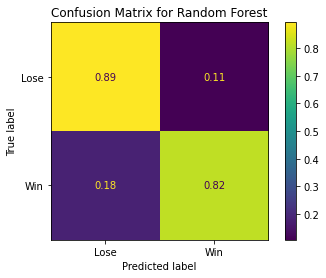

In [284]:
ax = ConfusionMatrixDisplay(confusion_matrix(y_test, lrsvm.predict(X_test), normalize='true'), display_labels=['Lose','Win'])
ax.plot()
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [267]:
impts_svm = lrsvm.best_estimator_.coef_[0]
print("Important features identified by SVM:")
X_train.columns[np.argsort(-1*impts_svm)[:5]]

Important features identified by SVM:


Index(['towerKills', 'firstInhibitor', 'firstTower', 'firstBaron',
       'firstDragon'],
      dtype='object')

### Test Accuracy Comparison

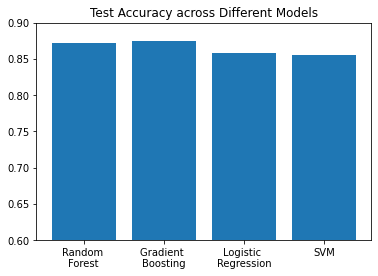

In [255]:
plt.bar(height=accs, x=['Random \nForest', 'Gradient \nBoosting', 'Logistic \nRegression', 'SVM'])
plt.ylim([0.6,0.9])
plt.title('Test Accuracy across Different Models')
plt.show()

# Interpretation
All models achieve a test accuracy over 85%. Among them, Ensemble models generally outperform other models, since ensembles are good at taking care of categorical data (Ex. "firstTower"), while other models like Logistic Regression actually suffer from categorical data. According to the confusion matrix, we can discover further that both ensembles predict the winning and losing teams accurately, with 86% accuracy for predicting losing teams and 88% accuracy for predicting winning teams. For Logistic Regression and SVM, however, despite a pretty good accuracy for predicting losing teams, they fail to correctly predict winning teams.     

This weird case can be explained by looking into the top features selected by each model. Three factors, 'towerKills', 'firstTower', and 'firstInhibitor', are present in all models. This is expected, since towers and inhibitors are the most important objectives in League of Legends. With fewer tower, your team gains less vision, and thus is more vulnerable to enemy attacks. On the other hand, the rest of the top features display a different pattern. Both ensemble models choose features relevant to dragons, but the other two models include a feature related to Baron. In League of Legends, dragons are late-game neutral objectives while Barons are early-mid game objectives. In 2020, the patches lowered the weight of early-game advantages, effectively reducing the importance of Baron, especially the first Baron acquired. For Logistic Regression and SVM, they both incorrectly put too much weight on Baron, which leads to their a-bit-worse performance in predicting winning teams compared to ensembles. This also proves the correctness of ensembles in predicting a team's winning chance.
                                                 
In conclusion, ensembles do a better job in predicting whether a team wins in a League of Legends match.